# 🧪 Fertilizer Dosage Prediction Pipeline (Tunisia)

This notebook presents a complete machine learning workflow to **predict optimal fertilizer dosage** using real-world agricultural data from Tunisia.

### 📌 Key Components:
- **Exploratory Data Analysis (EDA)**: Understand data distributions and correlations
- **Data Preprocessing**: Handle missing values, outliers, skewness, and encoding
- **Feature Engineering**: Create interaction features and nutrient deficit metrics
- **Modeling & Tuning**: Models with `RandomizedSearchCV`
- **Evaluation**: MAE, RMSE, R², and insights into important predictors

> 🚜 BO:
Provide accurate fertilizer dosage recommendations to improve crop yield and reduce waste in Tunisia.

>DSO:
Build a regression model to predict optimal fertilizer dosage based on soil, crop, and fertilizer data.



# **Data understanding**

In [1]:
from google.colab import files
import pandas as pd

# Upload file manually
uploaded = files.upload()

Saving dosage_crop.csv to dosage_crop.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import missingno as msno

In [3]:
data = pd.read_csv('dosage_crop.csv', delimiter=';', encoding='utf-8')
print(data.shape)

# Display sample data and info
display(data.head())
data.info()
print(data.describe())


(10000, 20)


,Fertilizer Name,N (%),P (%),K (%),Fertilizer Type,Absorption Rate (%),Price per kg (TND),State,Region of Use in Tunisia,Specific Crop,Crop N,Crop P,Crop K,Application Method,Root Depth (cm),Soil_P,Soil_K,Soil_N,pH,Usage (Dosage)
0,BIOFERT ORGANIC,15,15,10,Organic,75,2.99,Sidi Bouzid,Central,Corn,142,61,34,Radicular,70,11.600000,77.300000,21.300000,7.286931,7.88
1,FLOCROP B,15,10,5,Liquid,70,2.34,Bizerte,North,Olive,146,70,40,Radicular and Foliar,80,28.446521,83.065767,46.385579,7.114031,13.93
2,FERTIMAX 15-15-15,15,15,15,Granular,60,3.23,Sousse,Central,Corn,142,61,34,Soil Application,70,NaN,61.697723,49.100000,7.686568,5.00
3,MOLYBDENUM PLUS,5,10,5,Chemical,79,2.06,Tataouine,South,Tomato,142,33,22,Foliar,45,22.931627,81.817345,23.831130,7.663094,15.23
4,MAP 11-52-0,11,52,0,Liquid,90,3.88,Monastir,Central,Potato,61,62,21,Soil Application,50,12.500000,92.300000,20.821715,7.825692,46.38


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fertilizer Name           10000 non-null  object 
 1   N (%)                     10000 non-null  int64  
 2   P (%)                     10000 non-null  int64  
 3   K (%)                     10000 non-null  int64  
 4   Fertilizer Type           10000 non-null  object 
 5   Absorption Rate (%)       10000 non-null  int64  
 6   Price per kg (TND)        10000 non-null  float64
 7   State                     10000 non-null  object 
 8   Region of Use in Tunisia  10000 non-null  object 
 9   Specific Crop             10000 non-null  object 
 10  Crop N                    10000 non-null  int64  
 11  Crop P                    10000 non-null  int64  
 12  Crop K                    10000 non-null  int64  
 13  Application Method        10000 non-null  object 
 14  Root De

In [4]:
data.shape

(10000, 20)

In [5]:
# List of categorical columns to analyze
un_cols = [
    'Fertilizer Name',
    'Fertilizer Type',
    'State',
    'Region of Use in Tunisia',
    'Specific Crop',
    'Application Method'
]

# Display unique values for each column
for col in un_cols:
    unique_vals = data[col].unique()
    print(f"\n🔹 {col} ({len(unique_vals)} unique values):")
    print(np.sort(unique_vals))  # Sorted output for better readability


🔹 Fertilizer Name (154 unique values):
['ACA 27 ORGANIC' 'ACM AMINO 12 VEGETAL' 'ACM AMINO 45 SOLID' 'ACM BORO'
 'ACM CALCIO PLUS' 'ACM CITRUS' 'ACM COBRE' 'ACM FUL EXTRA' 'ACM HIERRO'
 'ACM HUMIC' 'ACM MAR 20' 'ACM MAR S' 'ACM POTASIO GEL' 'ACM SEAFORCE'
 'AGRI M40' 'AGRIFUL' 'AGRIPHYT CONTACT Zn-Mn' 'AGROGOLD 20-20-20'
 'ALGA-PLEX' 'ALGADUL' 'ALGALIV' 'ALGAMAX ORGANIC' 'ALGAPOWER'
 'AMINO Mn/Zn' 'AMINOPLUS ORGANIC' 'AMMONIUM SULFATE' 'ASCOFILLUM'
 'Ammonium Nitrate' 'BASFOLIAR SIZE SL' 'BESTCURE' 'BIFIDUS' 'BIOCAL'
 'BIOCALCIUM' 'BIOFERT ORGANIC' 'BIORADICANTE' 'BIOZINC' 'BLACKFORT'
 'BLACKJAK' 'BOMBARDIER' 'BOMBARDIER SUGAR' 'BORKO' 'BORON PLUS'
 'BOTAMISOL PRO 80' 'CALCIUM NITRATE' 'CALFERT 15-0-0 + 20CaO'
 'CALMAG 10-0-0 + 12CaO + 6MgO' 'CAOS XT' 'CONTROLPHYT Cu'
 'COPPER SULFATE' 'CRIPTHUM' 'CUPRO ACTIV' 'DAP' 'DAP 18-46-0'
 'DCM VIVIKALI' 'DEFENDER CALCIO' 'DEFENDER MZ' 'ECKLOMAR' 'ECOFERT 5-3-4'
 'ECORMON' 'ESPARTAN' 'FARINA DI BASALTO' 'FERROACTIV H48'
 'FERTICROP ORGANIC PLU

In [6]:
# Check for missing values
missing = data.isnull().sum()
print("Missing values:\n", missing[missing > 0])


Missing values:
 Soil_P    212
Soil_K    207
Soil_N    202
dtype: int64


## **Data Understanding & EDA**

In [7]:
'''# Supprimer les lignes où le dosage est supérieur à 400
data = data[data["Usage (Dosage)"] <= 400]

# Sauvegarder le nouveau fichier
data.to_csv("augmented_filtered.csv", sep=';', index=False)
'''

'# Supprimer les lignes où le dosage est supérieur à 400\ndata = data[data["Usage (Dosage)"] <= 400]\n\n# Sauvegarder le nouveau fichier\ndata.to_csv("augmented_filtered.csv", sep=\';\', index=False)\n'

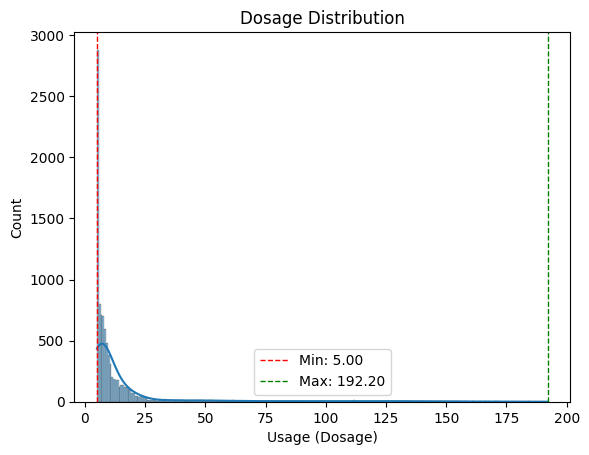

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram with KDE
sns.histplot(data['Usage (Dosage)'], kde=True)
plt.title('Dosage Distribution')

# Calculate min and max
min_val = data['Usage (Dosage)'].min()
max_val = data['Usage (Dosage)'].max()

# Add vertical lines for min and max
plt.axvline(min_val, color='red', linestyle='--', linewidth=1, label=f'Min: {min_val:.2f}')
plt.axvline(max_val, color='green', linestyle='--', linewidth=1, label=f'Max: {max_val:.2f}')

# Add legend to show the values
plt.legend()

# Alternatively, you can use text annotations
# plt.text(min_val, plt.ylim()[1]*0.9, f'Min: {min_val:.2f}', color='red')
# plt.text(max_val, plt.ylim()[1]*0.8, f'Max: {max_val:.2f}', color='green')

plt.show()

The dosage distribution plot reveals a wide range of values, spanning from a minimum of 5.00 to a maximum of 192.20. This substantial spread (a 38-fold difference between the lowest and highest values) suggests several potential scenarios and analytical considerations

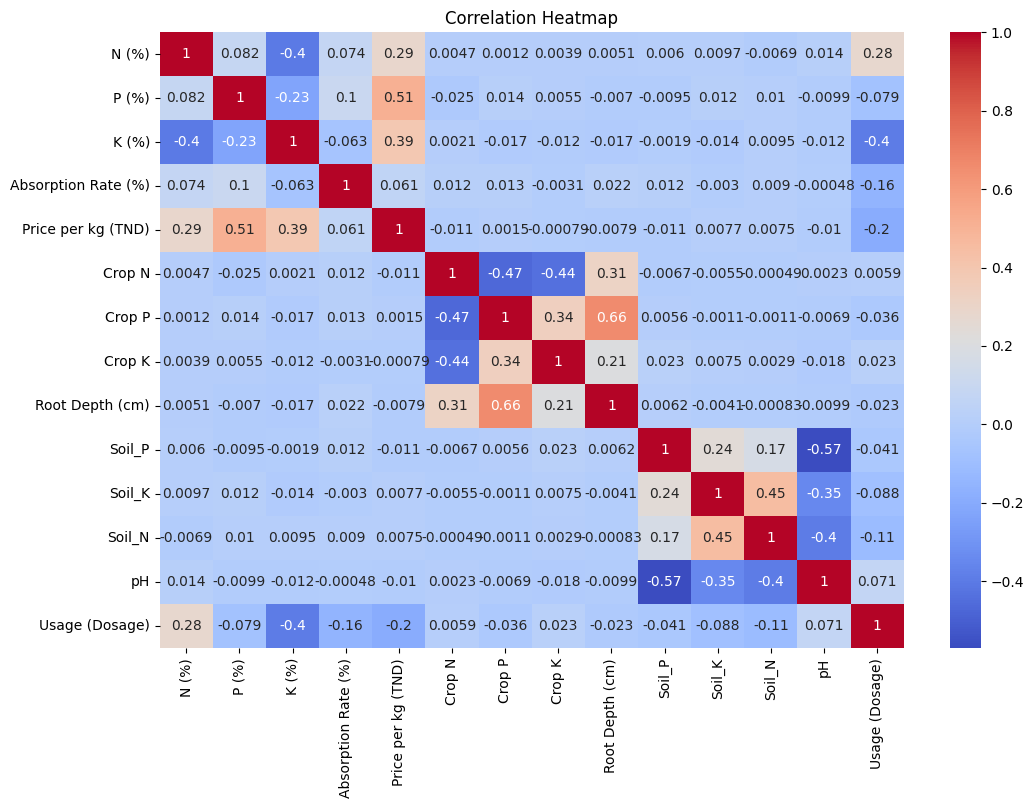

In [9]:
# Correlation heatmap
numeric_cols = data.select_dtypes(include=np.number)
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()



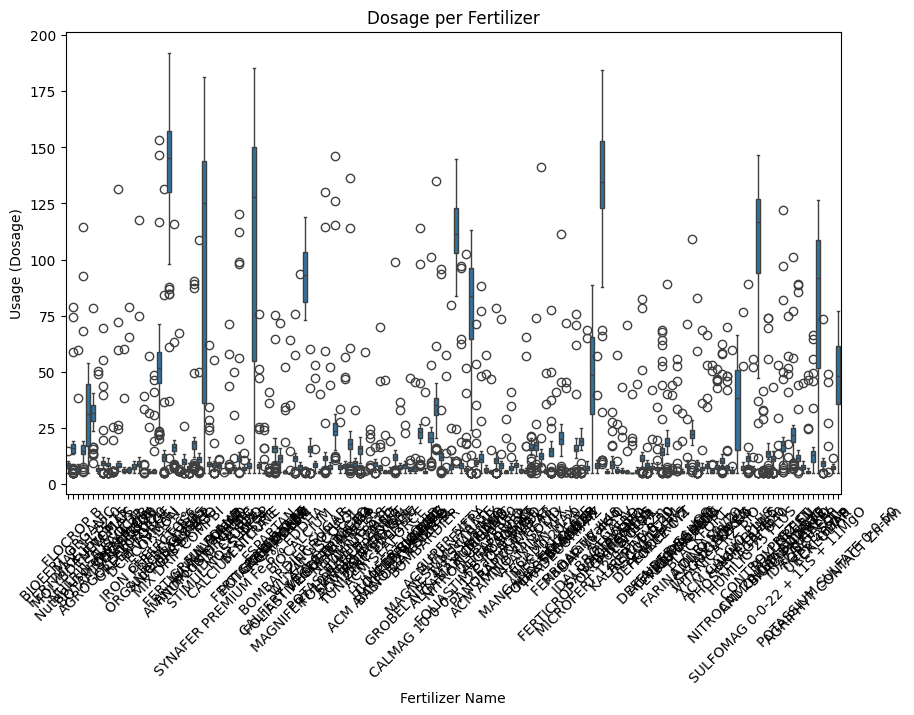

In [10]:
# Boxplot of dosage by fertilizer
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Fertilizer Name', y='Usage (Dosage)')
plt.xticks(rotation=45)
plt.title("Dosage per Fertilizer")
plt.show()

Text(0.5, 1.0, 'Nitrogen (N) Distribution')

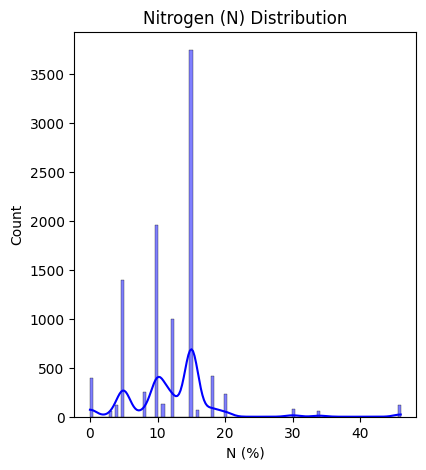

In [11]:
# =============================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# =============================================

# Nutrient composition analysis
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(data['N (%)'], kde=True, color='blue')
plt.title('Nitrogen (N) Distribution')



Text(0.5, 1.0, 'Phosphorus (P) Distribution')

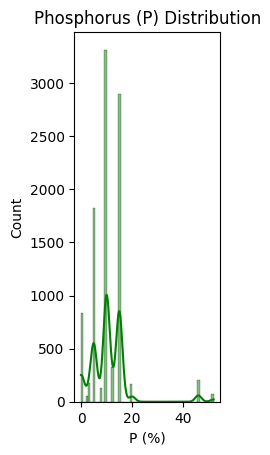

In [12]:
plt.subplot(1, 3, 2)
sns.histplot(data['P (%)'], kde=True, color='green')
plt.title('Phosphorus (P) Distribution')



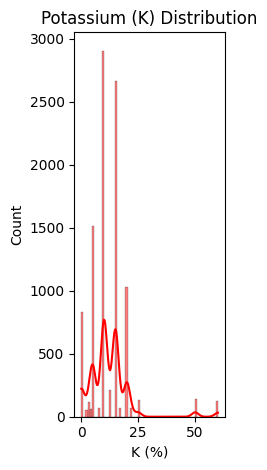

In [13]:
plt.subplot(1, 3, 3)
sns.histplot(data['K (%)'], kde=True, color='red')
plt.title('Potassium (K) Distribution')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'ph')

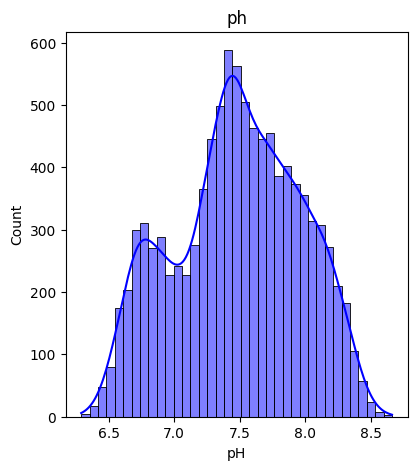

In [14]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(data['pH'], kde=True, color='blue')
plt.title('ph')



<ipython-input-15-6b8539a69c21>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Fertilizer Type', data=data, palette='viridis')


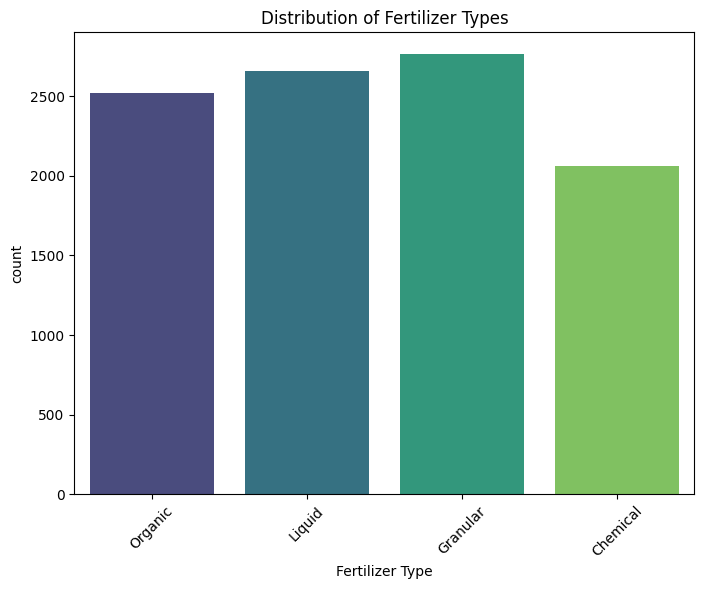

In [15]:
# Fertilizer type distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Fertilizer Type', data=data, palette='viridis')
plt.title('Distribution of Fertilizer Types')
plt.xticks(rotation=45)
plt.show()

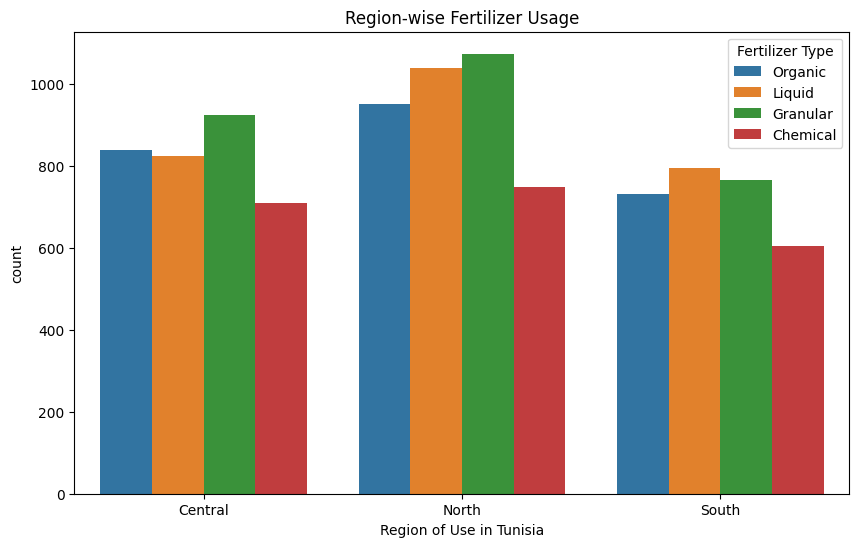

In [16]:
# 3. Region-wise Fertilizer Usage
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Region of Use in Tunisia', hue='Fertilizer Type')
plt.title("Region-wise Fertilizer Usage")
plt.show()


North: Prefers Liquid & Organic fertilizers.
South: Highest Liquid fertilizer use (~100 count).
Central: More Chemical fertilizers used than other regions.
🔹 Modeling Insight: Region is a key factor in fertilizer recommendation. Consider interaction effects between Region & Fertilizer Type.

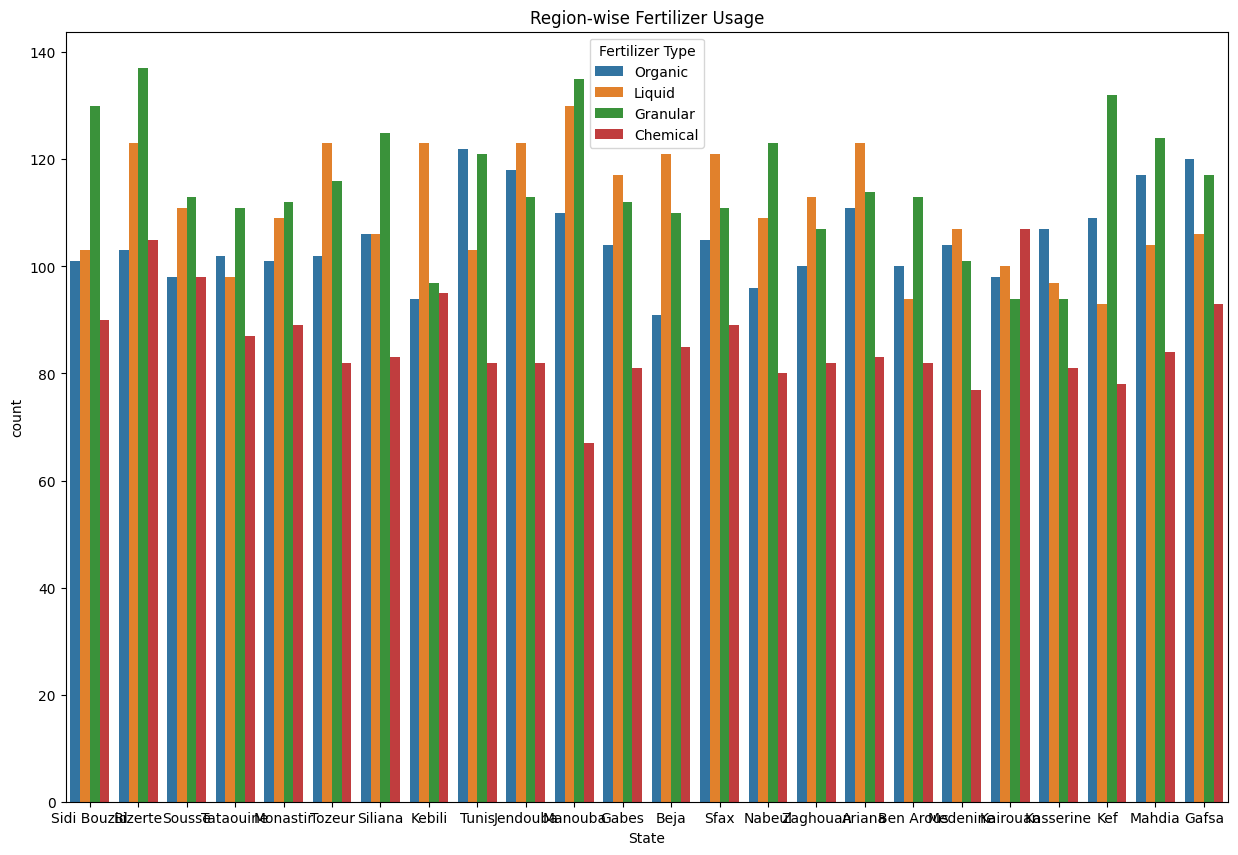

In [17]:
# State wise Fertilizer Usage
plt.figure(figsize=(15, 10))
sns.countplot(data=data, x='State', hue='Fertilizer Type')
plt.title("Region-wise Fertilizer Usage")
plt.show()


# **Data Preparation**

Skewness of Dosage: 3.618403581672022


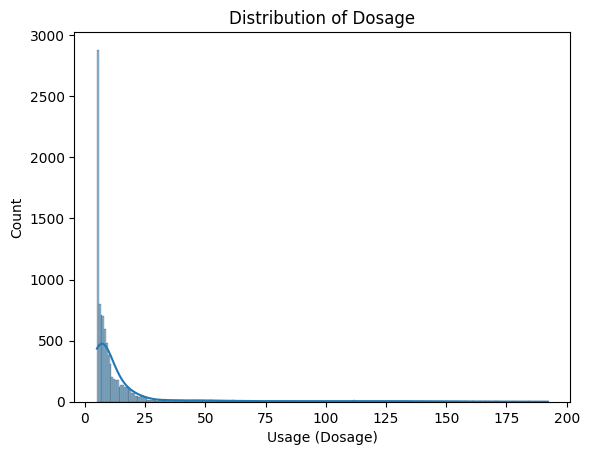

In [18]:
print("Skewness of Dosage:", data['Usage (Dosage)'].skew())
sns.histplot(data['Usage (Dosage)'], kde=True)
plt.title("Distribution of Dosage")
plt.show()

In [19]:
# -----------------------------------
# 1. CONVERT NUMERIC STRINGS TO FLOAT
# -----------------------------------
numeric_columns = [
    'N (%)', 'P (%)', 'K (%)', 'Absorption Rate (%)', 'Price per kg (TND)',
    'Soil_N', 'Soil_P', 'Soil_K', 'Crop N', 'Crop P', 'Crop K',
    'Root Depth (cm)', 'pH', 'Usage (Dosage)'
]
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [20]:
# Soil-specific imputation (median per region)
for nutrient in ['Soil_N', 'Soil_P', 'Soil_K']:
    data[nutrient] = data.groupby('Region of Use in Tunisia')[nutrient].transform(
        lambda x: x.fillna(x.median())
    )

# Fallback to overall median if regional data is unavailable
soil_cols = ['Soil_N', 'Soil_P', 'Soil_K']
data[soil_cols] = data[soil_cols].fillna(data[soil_cols].median())

In [21]:
'''original_size = len(data)
data = data.dropna(subset=['Usage (Dosage)'])
print(f"Removed {original_size - len(data)} rows with missing dosage")'''

'original_size = len(data)\ndata = data.dropna(subset=[\'Usage (Dosage)\'])\nprint(f"Removed {original_size - len(data)} rows with missing dosage")'

In [22]:
# Check for missing values
missing = data.isnull().sum()
print("Missing values:\n", missing[missing > 0])


Missing values:
 Series([], dtype: int64)


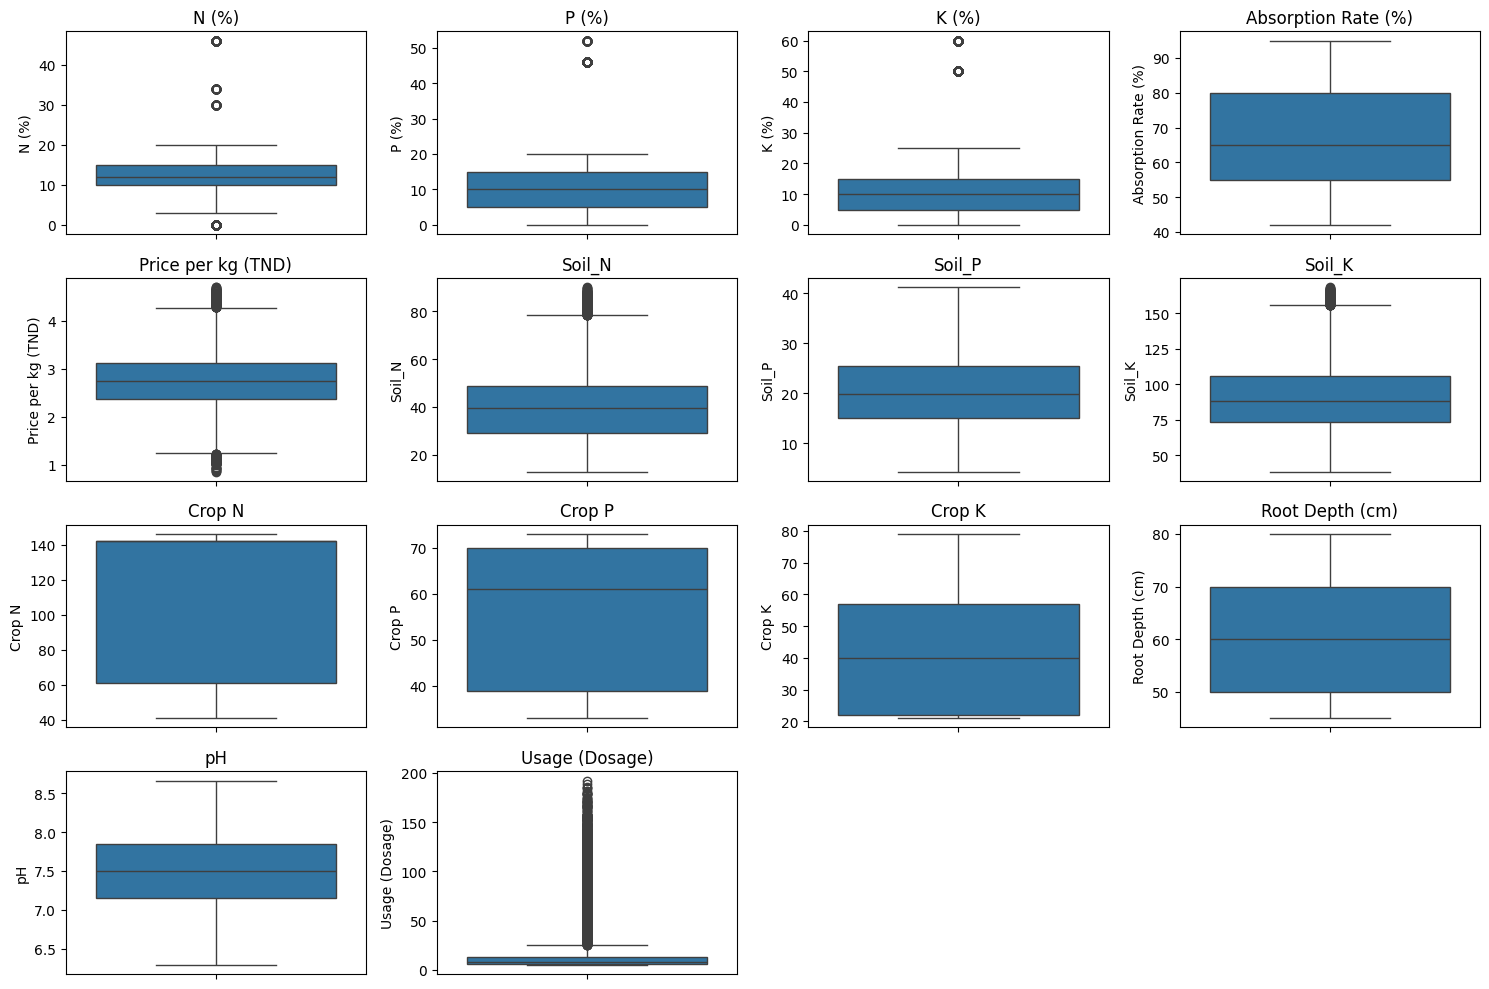

In [23]:
# 5. Check for Outliers
# Visualize outliers using boxplots for numerical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [24]:
# 1. Cap features (exclude target)
features_to_cap = [col for col in numeric_columns if col != 'Usage (Dosage)']
for col in features_to_cap:
    q_low, q_high = data[col].quantile([0.05, 0.95])
    data[col] = np.clip(data[col], q_low, q_high)

# Recalculate skew without 'Usage (Dosage)'
numeric_features = [col for col in numeric_columns if col != 'Usage (Dosage)']
skewed = data[numeric_features].skew()
to_log = skewed[abs(skewed) > 1.5].index

# Apply log1p only to highly skewed features (excluding target)
data[to_log] = data[to_log].apply(np.log1p)


Skewness of Dosage: 3.618403581672022


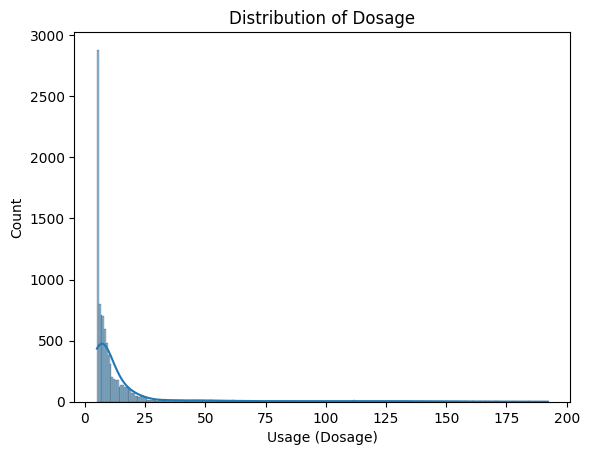

In [25]:
print("Skewness of Dosage:", data['Usage (Dosage)'].skew())
sns.histplot(data['Usage (Dosage)'], kde=True)
plt.title("Distribution of Dosage")
plt.show()

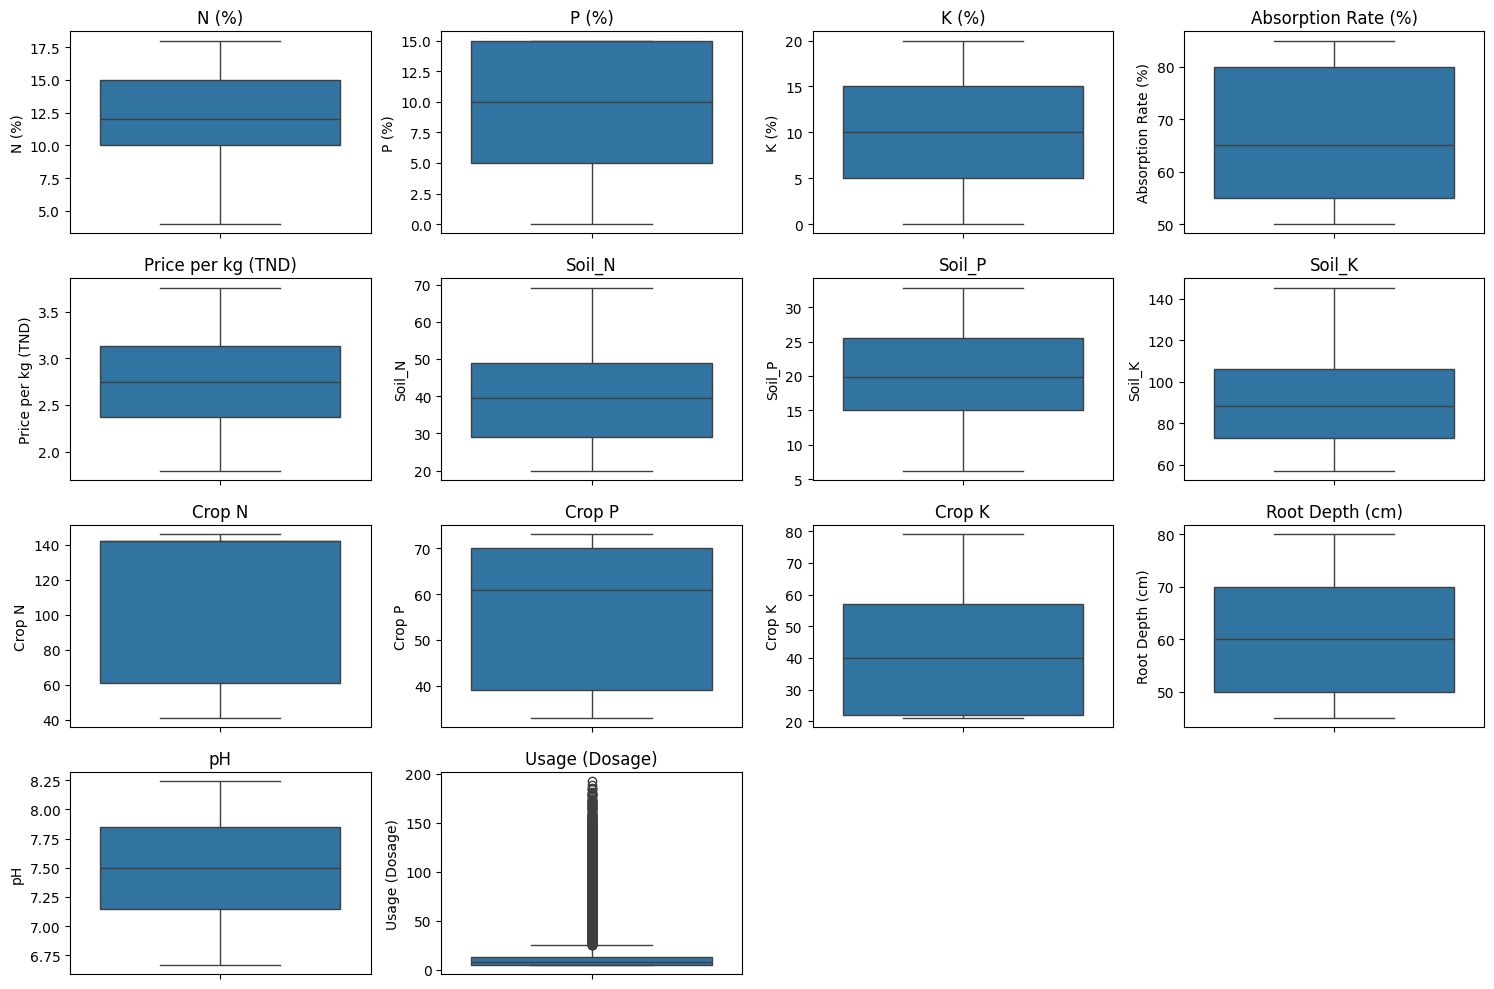

In [26]:
# Visualisation des outliers (après capping + log)
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

pH Value Counts:
pH
6.667173    500
6.667185      1
6.667220      1
6.667989      1
6.668200      1
           ... 
8.238768      1
8.238952      1
8.239131      1
8.239261      1
8.239270    500
Name: count, Length: 9002, dtype: int64

pH Distribution Stats:
count    10000.000000
mean         7.481490
std          0.462659
min          6.667173
25%          7.150646
50%          7.495166
75%          7.846404
max          8.239270
Name: pH, dtype: float64


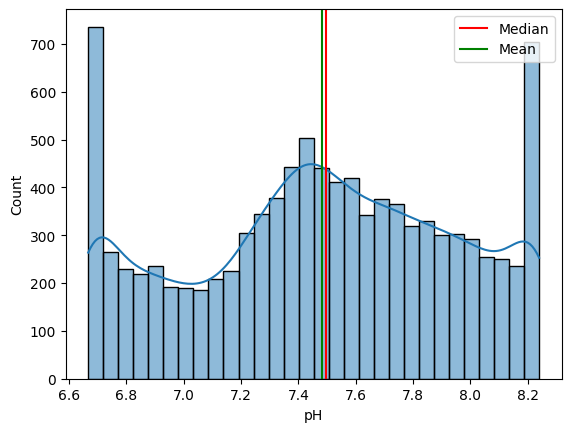

In [27]:
print("pH Value Counts:")
print(data['pH'].value_counts().sort_index())

print("\npH Distribution Stats:")
print(data['pH'].describe())

sns.histplot(data['pH'], bins=30, kde=True)
plt.axvline(x=data['pH'].median(), color='red', label='Median')
plt.axvline(x=data['pH'].mean(), color='green', label='Mean')
plt.legend()

In [28]:
data["NPK_ratio"] = data["N (%)"] / (data["P (%)"] + data["K (%)"] + 1e-3)

data["N_gap"] = data["Crop N"] - data["N (%)"]
data["P_gap"] = data["Crop P"] - data["P (%)"]
data["K_gap"] = data["Crop K"] - data["K (%)"]

data["Soil_P_suff"] = data["Soil_P"] / (data["Crop P"] + 1e-3)
data["Soil_K_suff"] = data["Soil_K"] / (data["Crop K"] + 1e-3)
data["Soil_N_suff"] = data["Soil_N"] / (data["Crop N"] + 1e-3)

data["N_gap"] = data["Crop N"] - data["N (%)"]
data["P_gap"] = data["Crop P"] - data["P (%)"]
data["K_gap"] = data["Crop K"] - data["K (%)"]

data["Effective_N"] = data["N (%)"] * data["Absorption Rate (%)"] / 100
data["Effective_P"] = data["P (%)"] * data["Absorption Rate (%)"] / 100
data["Effective_K"] = data["K (%)"] * data["Absorption Rate (%)"] / 100




| Feature         | Meaning                                                                |
|----------------|------------------------------------------------------------------------|
| `NPK_ratio`     | Fertilizer formulation skew — how N-heavy it is.                       |
| `*_gap`         | Nutrient need vs fertilizer content.                                   |
| `Soil_*_suff`   | How much the soil alone contributes toward fulfilling crop needs.      |
| `Effective_*`   | Adjusted fertilizer nutrient availability, considering absorption rate. |


Top correlated features with Usage (Dosage):
Usage (Dosage)         1.000000
NPK_ratio              0.662345
K_gap                  0.174096
N (%)                  0.079895
pH                     0.070551
P_gap                  0.057044
Crop K                 0.023058
Effective_N            0.014854
Crop N                 0.005879
N_gap                 -0.002226
Soil_P_suff           -0.011022
Root Depth (cm)       -0.023340
Crop P                -0.035893
Soil_K_suff           -0.040622
Soil_P                -0.041439
Soil_K                -0.078500
Soil_N_suff           -0.094766
Soil_N                -0.113080
Absorption Rate (%)   -0.149842
Price per kg (TND)    -0.192225
P (%)                 -0.303378
Effective_P           -0.320578
Effective_K           -0.537118
K (%)                 -0.551847
Name: Usage (Dosage), dtype: float64


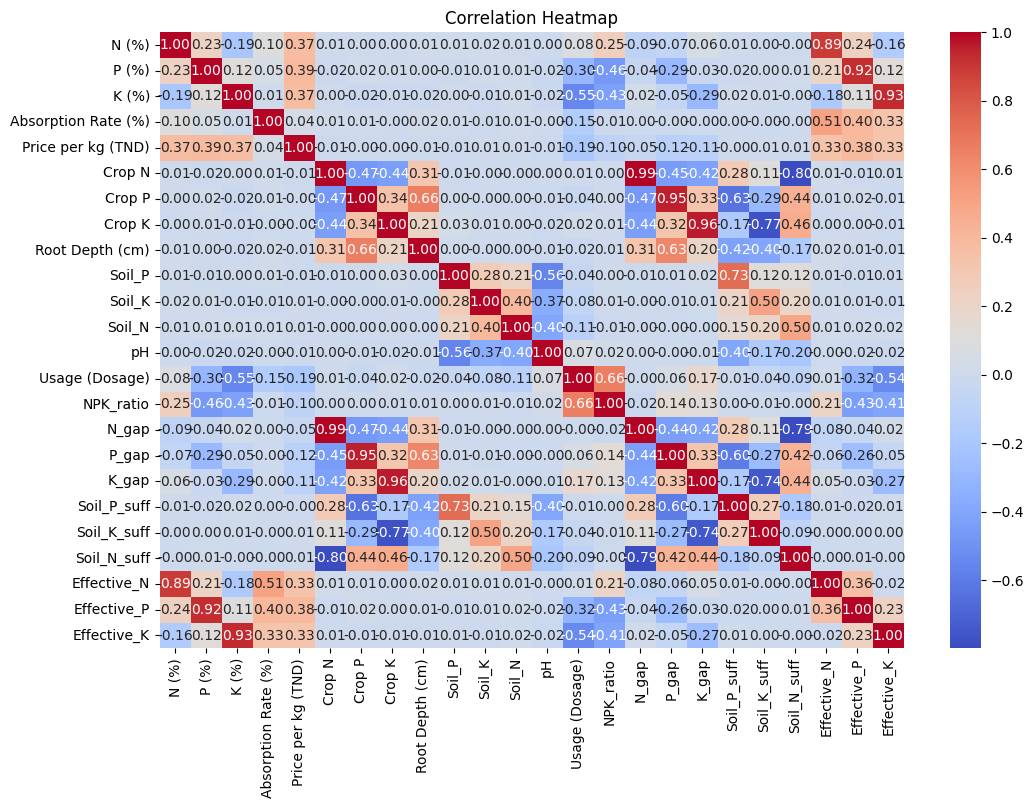

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric features
numerical_features = data.select_dtypes(include=['float64', 'int64'])

# Compute correlation with the target
correlation_with_target = numerical_features.corr()['Usage (Dosage)'].sort_values(ascending=False)

# Display top correlations
print("Top correlated features with Usage (Dosage):")
print(correlation_with_target)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


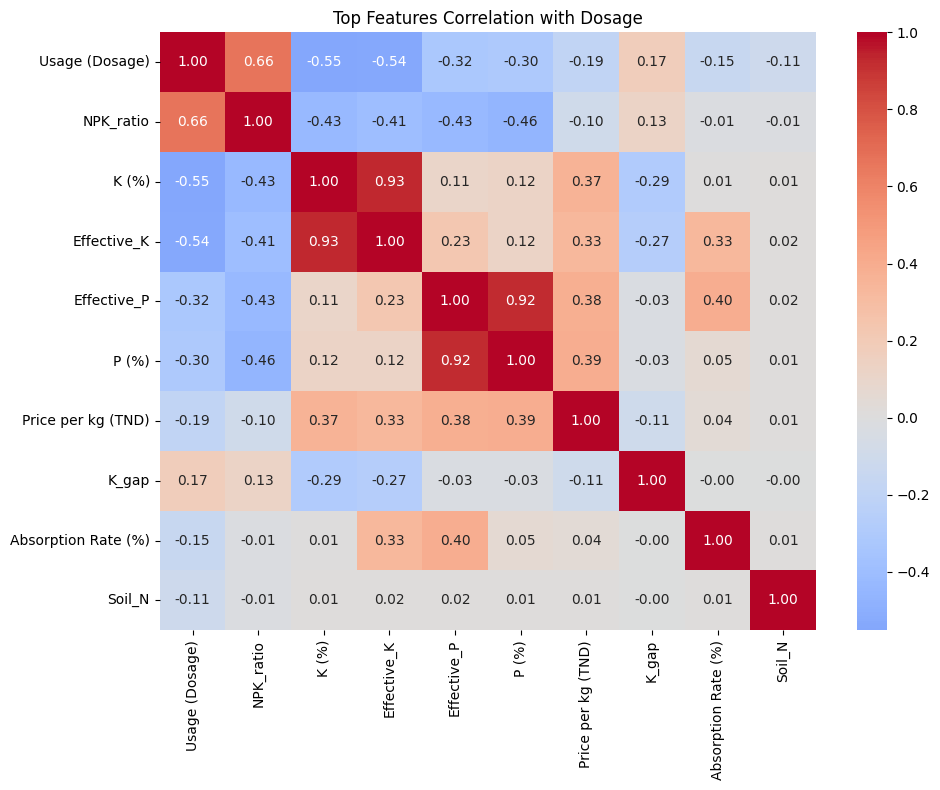

In [30]:
# Select top 10 features most correlated with dosage
top_features = correlation_with_target.abs().sort_values(ascending=False).index[:10]
focused_corr = numerical_features[top_features].corr()

# Create a smaller heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(focused_corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title("Top Features Correlation with Dosage")
plt.tight_layout()
plt.show()

In [31]:
# Get top 10 features correlated with dosage
top_features = correlation_with_target.abs().sort_values(ascending=False).index[:10]
top_correlations = correlation_with_target[top_features]

# Print formatted correlation report
print("="*60)
print("FERTILIZER DOSAGE CORRELATION ANALYSIS REPORT")
print("="*60)

print("\nTOP FEATURES CORRELATED WITH DOSAGE (Usage (Dosage)):")
print("-"*55)
for feature, corr in top_correlations.items():
    strength = ""
    if abs(corr) >= 0.7: strength = "VERY STRONG"
    elif abs(corr) >= 0.5: strength = "STRONG"
    elif abs(corr) >= 0.3: strength = "MODERATE"
    else: strength = "WEAK"

    direction = "increases with" if corr > 0 else "decreases with"
    print(f"{feature:>20}: {corr:.2f} ({strength} {direction} dosage)")

# Get inter-feature correlations
print("\nTOP INTER-FEATURE CORRELATIONS (Potential Multicollinearity):")
print("-"*55)
focused_corr = numerical_features[top_features].corr().abs()

# Get top 5 inter-feature correlations (excluding self-correlation and duplicates)
corr_pairs = (focused_corr.where(np.triu(np.ones(focused_corr.shape), k=1).astype(bool))
              .stack()
              .sort_values(ascending=False)
              .head(5))

for (feature1, feature2), corr in corr_pairs.items():
    print(f"{feature1:>20} ↔ {feature2:<20}: {corr:.2f}")



FERTILIZER DOSAGE CORRELATION ANALYSIS REPORT

TOP FEATURES CORRELATED WITH DOSAGE (Usage (Dosage)):
-------------------------------------------------------
      Usage (Dosage): 1.00 (VERY STRONG increases with dosage)
           NPK_ratio: 0.66 (STRONG increases with dosage)
               K (%): -0.55 (STRONG decreases with dosage)
         Effective_K: -0.54 (STRONG decreases with dosage)
         Effective_P: -0.32 (MODERATE decreases with dosage)
               P (%): -0.30 (MODERATE decreases with dosage)
  Price per kg (TND): -0.19 (WEAK decreases with dosage)
               K_gap: 0.17 (WEAK increases with dosage)
 Absorption Rate (%): -0.15 (WEAK decreases with dosage)
              Soil_N: -0.11 (WEAK decreases with dosage)

TOP INTER-FEATURE CORRELATIONS (Potential Multicollinearity):
-------------------------------------------------------
               K (%) ↔ Effective_K         : 0.93
         Effective_P ↔ P (%)               : 0.92
      Usage (Dosage) ↔ NPK_ratio    

# 📈 Fertilizer Dosage – Correlation Analysis Report

This report summarizes the **relationships between engineered features** and the target variable: **`Usage (Dosage)`**. It also highlights potential **multicollinearity issues** among features that might affect model performance or interpretability.

---

## 🎯 Top Features Correlated with Dosage (`Usage (Dosage)`)

| Feature                | Correlation | Strength      | Interpretation                                 |
|------------------------|-------------|----------------|------------------------------------------------|
| `Usage (Dosage)`       | 1.00        | 🚨 VERY STRONG | Reference point — self-correlation             |
| `NPK_ratio`            | +0.66       | 🔥 STRONG      | N-dominant fertilizers often require higher dosage |
| `K (%)`                | -0.55       | 🔥 STRONG      | Potassium-rich fertilizers tend to be used at lower dosages |
| `Effective_K`          | -0.54       | 🔥 STRONG      | More bioavailable K → less dosage needed       |
| `Effective_P`          | -0.32       | ✅ MODERATE    | Bioavailable phosphorus reduces dosage         |
| `P (%)`                | -0.30       | ✅ MODERATE    | More P in the fertilizer → lower overall usage |
| `Price per kg (TND)`   | -0.19       | 🟡 WEAK        | More expensive fertilizers may be applied more sparingly |
| `K_gap`                | +0.17       | 🟡 WEAK        | Larger K deficiencies may require higher dosage |
| `Absorption Rate (%)`  | -0.15       | 🟡 WEAK        | Higher absorption = more efficient → less fertilizer needed |
| `Soil_N`               | -0.11       | 🟡 WEAK        | Richer soil nitrogen reduces the fertilizer dose |

---

## ⚠️ Top Inter-Feature Correlations (Multicollinearity)

| Feature Pair                     | Correlation | Implication                                          |
|----------------------------------|-------------|------------------------------------------------------|
| `K (%)` ↔ `Effective_K`          | +0.93       | Very high correlation — likely redundant            |
| `P (%)` ↔ `Effective_P`          | +0.92       | Very high correlation — may need dimensionality reduction |
| `Usage (Dosage)` ↔ `NPK_ratio`   | +0.66       | Fertilizer N-dominance strongly influences dosage   |
| `Usage (Dosage)` ↔ `K (%)`       | -0.55       | Potassium content inversely impacts dosage          |
| `Usage (Dosage)` ↔ `Effective_K` | -0.54       | Bioavailable K is a key driver of reduced dosage    |

---

## ✅ Insights Summary

- **Fertilizer composition** (especially NPK balance and nutrient gaps) heavily influences how much dosage is applied.
- **Soil nutrient richness** and **fertilizer efficiency** (via `Absorption Rate` and `Effective_*`) help **reduce the required dosage**.
- **Multicollinearity** among some features (e.g., `P (%)` vs `Effective_P`)

In [32]:
# Drop only one of each high-corr pair to reduce redundancy
'''data = data.drop(columns=['K_Abs_Deficit'], errors='ignore')'''


"data = data.drop(columns=['K_Abs_Deficit'], errors='ignore')"

In [33]:

# Colonnes catégorielles
categorical_columns = data.select_dtypes(include=['object']).columns
print("\nColonnes catégorielles :")
print(categorical_columns)


Colonnes catégorielles :
Index(['Fertilizer Name', 'Fertilizer Type', 'State',
       'Region of Use in Tunisia', 'Specific Crop', 'Application Method'],
      dtype='object')


In [34]:
numerical_columns = data.select_dtypes(include=['number']).columns
# Afficher les résultats
print("Colonnes numériques :")
print(numerical_columns)

Colonnes numériques :
Index(['N (%)', 'P (%)', 'K (%)', 'Absorption Rate (%)', 'Price per kg (TND)',
       'Crop N', 'Crop P', 'Crop K', 'Root Depth (cm)', 'Soil_P', 'Soil_K',
       'Soil_N', 'pH', 'Usage (Dosage)', 'NPK_ratio', 'N_gap', 'P_gap',
       'K_gap', 'Soil_P_suff', 'Soil_K_suff', 'Soil_N_suff', 'Effective_N',
       'Effective_P', 'Effective_K'],
      dtype='object')


In [35]:
from sklearn.preprocessing import LabelEncoder

# ✅ Colonnes à encoder avec LabelEncoder
label_cols = ['Fertilizer Name', 'Fertilizer Type', 'Region of Use in Tunisia', 'State', 'Specific Crop', 'Application Method']
encoders = {}  # Pour stocker les encodeurs si besoin de décoder plus tard

for col in label_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    encoders[col] = le

In [36]:
'''# 2. Détection des colonnes numériques très asymétriques
# -------------------------------
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('Dosage')  # ⚠️ On exclut la cible

skewed = data[numeric_columns].skew()
to_log = skewed[abs(skewed) > 1.5].index

# -------------------------------
# 3. Application de la log-transformation
# -------------------------------
data[to_log] = data[to_log].apply(lambda x: np.log1p(x))
print("🔁 Colonnes log-transformées :", list(to_log))

# Optionnel : vérifier la skewness après log
print("\n📈 Skewness après log :")
print(data[to_log].skew())'''

'# 2. Détection des colonnes numériques très asymétriques\n# -------------------------------\nnumeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()\nnumeric_columns.remove(\'Dosage\')  # ⚠️ On exclut la cible\n\nskewed = data[numeric_columns].skew()\nto_log = skewed[abs(skewed) > 1.5].index\n\n# -------------------------------\n# 3. Application de la log-transformation\n# -------------------------------\ndata[to_log] = data[to_log].apply(lambda x: np.log1p(x))\nprint("🔁 Colonnes log-transformées :", list(to_log))\n\n# Optionnel : vérifier la skewness après log\nprint("\n📈 Skewness après log :")\nprint(data[to_log].skew())'

In [37]:
# -----------------------------
# 8. CHECK MISSING DATA
# -----------------------------
print("🔍 Missing values:", data.isnull().sum().sum())


🔍 Missing values: 0


In [38]:
# Colonnes numériques
numerical_columns = data.select_dtypes(include=['number']).columns

# Colonnes catégorielles
categorical_columns = data.select_dtypes(include=['object']).columns

# Afficher les résultats
print("Colonnes numériques :")
print(numerical_columns)

print("\nColonnes catégorielles :")
print(categorical_columns)

Colonnes numériques :
Index(['Fertilizer Name', 'N (%)', 'P (%)', 'K (%)', 'Fertilizer Type',
       'Absorption Rate (%)', 'Price per kg (TND)', 'State',
       'Region of Use in Tunisia', 'Specific Crop', 'Crop N', 'Crop P',
       'Crop K', 'Application Method', 'Root Depth (cm)', 'Soil_P', 'Soil_K',
       'Soil_N', 'pH', 'Usage (Dosage)', 'NPK_ratio', 'N_gap', 'P_gap',
       'K_gap', 'Soil_P_suff', 'Soil_K_suff', 'Soil_N_suff', 'Effective_N',
       'Effective_P', 'Effective_K'],
      dtype='object')

Colonnes catégorielles :
Index([], dtype='object')


In [39]:
# Sauvegarder dans un fichier .csv
data.to_csv("fichier_encode.csv", index=False)
print("\nFichier encodé sauvegardé sous : fichier_encode.csv")


Fichier encodé sauvegardé sous : fichier_encode.csv


In [40]:
# -----------------------------
# 9. FINAL TRAIN-TEST SPLIT
# -----------------------------
X = data.drop(columns=['Usage (Dosage)', 'Fertilizer Name'], errors='ignore')

y = data['Usage (Dosage)']

In [41]:
# ============================
# 10. Train-Test Split
# ============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ Final train-test shape:", X_train.shape, X_test.shape)


✅ Final train-test shape: (8000, 28) (2000, 28)


In [42]:
# ============================
# 10.1 Print Feature Order
# ============================
print("\n✅ Feature Order used for training:")
for idx, col in enumerate(X_train.columns):
    print(f"{idx+1}. {col}")


✅ Feature Order used for training:
1. N (%)
2. P (%)
3. K (%)
4. Fertilizer Type
5. Absorption Rate (%)
6. Price per kg (TND)
7. State
8. Region of Use in Tunisia
9. Specific Crop
10. Crop N
11. Crop P
12. Crop K
13. Application Method
14. Root Depth (cm)
15. Soil_P
16. Soil_K
17. Soil_N
18. pH
19. NPK_ratio
20. N_gap
21. P_gap
22. K_gap
23. Soil_P_suff
24. Soil_K_suff
25. Soil_N_suff
26. Effective_N
27. Effective_P
28. Effective_K


In [43]:
'''# Normalisation pour Ridge uniquement
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)'''

'# Normalisation pour Ridge uniquement\nscaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train)\nX_test_scaled = scaler.transform(X_test)'

# **Modeling + Evaluation**


We will evaluate the following regression models to predict `Usage (Dosage)`:

1. **Tree-Based Models**  
   - `RandomForestRegressor`  
   - `XGBRegressor` (XGBoost)  
   - `GradientBoostingRegressor`  
   - `HistGradientBoostingRegressor` (scikit-learn's optimized implementation)  
   - `CatBoostRegressor` (Handles categorical features natively)  



2. **Ensemble & Advanced Methods**  
   - `StackingRegressor` (Meta-estimator combining `hist` + `CatBoost` predictions)  
   

**Rationale**:  
- **Tree-based models** to capture non-linear relationships (e.g., strong negative `K (%)` effect).  
- **Ridge regression** as a simple, interpretable baseline.  
- **Stacking/FNN** to test if hybrid/deep learning improves upon standalone models.  

## **Random Forest Regressor**

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error',
    random_state=42
)

start = time.time()
rf_search.fit(X_train, y_train)
rf_preds = rf_search.predict(X_test)
end = time.time()

print("📊 Random Forest (Amélioré)")
print(f"Best Parameters: {rf_search.best_params_}")
print("RMSE:", mean_squared_error(y_test, rf_preds) ** 0.5)
print("MAE:", mean_absolute_error(y_test, rf_preds))
print("R²:", r2_score(y_test, rf_preds))
print("Training Time (s):", round(end - start, 2))






Fitting 3 folds for each of 5 candidates, totalling 15 fits
📊 Random Forest (Amélioré)
Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}
RMSE: 6.719154256547553
MAE: 2.230186341291472
R²: 0.947221213213954
Training Time (s): 62.85


In [45]:
import joblib

# Save the entire pipeline with hyperparameters and best estimator
joblib.dump(rf_search, 'randomForest.pkl')


['randomForest.pkl']

## **XGBRegressor**

In [46]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# Définition de la grille des hyperparamètres à tester
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialisation du modèle XGBRegressor
xgb = XGBRegressor(n_jobs=-1, verbosity=0, random_state=42)

# Paramètres pour RandomizedSearchCV
xgb_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=10,  # Increase iterations for more exploration
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error',
    random_state=42
)


# Enregistrement du temps d'entraînement
start = time.time()

# Entraînement du modèle avec la recherche d'hyperparamètres
xgb_search.fit(X_train, y_train)

# Prédiction sur le jeu de test
xgb_preds = xgb_search.predict(X_test)

# Temps de formation
end = time.time()

# Affichage des résultats
print("📊 XGBoost (Amélioré)")
print(f"Best Parameters: {xgb_search.best_params_}")
print("RMSE:", mean_squared_error(y_test, xgb_preds) ** 0.5)
print("MAE:", mean_absolute_error(y_test, xgb_preds))
print("R²:", r2_score(y_test, xgb_preds))
print("Training Time (s):", round(end - start, 2))

# Affichage des premières prédictions vs réelles pour voir la performance
print("\nComparaison des prédictions et valeurs réelles (top 5):")
comparison = pd.DataFrame({'Réelles': y_test[:5], 'Prédites': xgb_preds[:5]})
print(comparison)







Fitting 3 folds for each of 10 candidates, totalling 30 fits
📊 XGBoost (Amélioré)
Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
RMSE: 5.6091864798668185
MAE: 1.9922365106725695
R²: 0.9632184576146177
Training Time (s): 32.31

Comparaison des prédictions et valeurs réelles (top 5):
      Réelles    Prédites
6252    62.43   59.891064
4684     8.13    8.158624
1731     7.52    7.403910
4742   148.29  134.957306
4521    98.90  117.945908


In [47]:
import joblib

# Save the entire pipeline with hyperparameters and best estimator
joblib.dump(xgb_search, 'xgboost.pkl')


['xgboost.pkl']

## **Gradient Boosting Regressor**

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

gb_pipeline = Pipeline([
    ('preprocessor', 'passthrough'),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

gb_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5]
}

gb_search = RandomizedSearchCV(gb_pipeline, gb_params, n_iter=20, cv=5,
                                scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)

start = time.time()
gb_search.fit(X_train, y_train)
end = time.time()

gb_preds = gb_search.predict(X_test)
gb_results = {
    'Model': 'Gradient Boosting',
    'RMSE': mean_squared_error(y_test, gb_preds) ** 0.5,
    'MAE': mean_absolute_error(y_test, gb_preds),
    'R²': r2_score(y_test, gb_preds),
    'Training Time (s)': round(end - start, 2),
    'Best Params': gb_search.best_params_
}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [49]:
# Show results
for k, v in gb_results.items():
    print(f"{k}: {v}")


Model: Gradient Boosting
RMSE: 5.630075965906725
MAE: 1.9724639626933889
R²: 0.9629439870681336
Training Time (s): 206.28
Best Params: {'regressor__n_estimators': 200, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1}


In [50]:
import joblib

# Save the entire pipeline with hyperparameters and best estimator
joblib.dump(gb_search, 'gradient_boosting_pipeline.pkl')


['gradient_boosting_pipeline.pkl']

## **HistGradientBoosting**

In [51]:
import time
import joblib
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 🔢 Define the pipeline
hgb_pipeline = Pipeline([
    ('preprocessor', 'passthrough'),  # If preprocessing is required, you can replace 'passthrough' with your custom transformer
    ('regressor', HistGradientBoostingRegressor(random_state=42))
])

# 🔧 Define the hyperparameters for RandomizedSearchCV
hgb_params = {
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_iter': [100, 200, 300],
    'regressor__max_depth': [None, 6, 10],
    'regressor__min_samples_leaf': [20, 50, 100],
    'regressor__l2_regularization': [0, 0.1, 1.0],
}


# 🔄 Perform RandomizedSearchCV
hgb_search = RandomizedSearchCV(hgb_pipeline, hgb_params, n_iter=10, cv=5,
                                 scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)

# 📊 Fit the model to training data
start = time.time()
hgb_search.fit(X_train, y_train)
end = time.time()

# 📊 Make predictions
hgb_preds = hgb_search.predict(X_test)

# 📈 Model results
hgb_results = {
    'Model': 'HistGradientBoosting',
    'RMSE': mean_squared_error(y_test, hgb_preds) ** 0.5,
    'MAE': mean_absolute_error(y_test, hgb_preds),
    'R²': r2_score(y_test, hgb_preds),
    'Training Time (s)': round(end - start, 2),
    'Best Params': hgb_search.best_params_
}

# 📢 Show the results
for k, v in hgb_results.items():
    print(f"{k}: {v}")

# 🧠 Save the trained model
joblib.dump(hgb_search, 'hgb_best_model.joblib')


Model: HistGradientBoosting
RMSE: 5.574955692898591
MAE: 2.0841857048867953
R²: 0.9636660160455665
Training Time (s): 37.63
Best Params: {'regressor__min_samples_leaf': 20, 'regressor__max_iter': 300, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.1, 'regressor__l2_regularization': 0.1}


['hgb_best_model.joblib']

In [52]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


## **CatBoostRegressor**

In [53]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# 🔢 Pipeline CatBoost
cat_pipeline = Pipeline([
    ('preprocessor', 'passthrough'),
    ('regressor', CatBoostRegressor(verbose=0, random_state=42, early_stopping_rounds=50))  # Early stopping ajouté
])

# 🔧 Hyperparamètres optimisés
cat_params = {
    'regressor__iterations': [200, 400, 600, 1000],  # Augmenter le nombre d'itérations
    'regressor__learning_rate': [0.01, 0.03, 0.05, 0.1],  # Valeurs de learning rate ajustées
    'regressor__depth': [4, 6, 8, 10],  # Profondeurs plus profondes
    'regressor__l2_leaf_reg': [1, 3, 5, 9, 10],  # Ajouter plus de régularisation
    'regressor__bootstrap_type': ['MVS'],  # Choisir uniquement 'MVS' pour éviter les erreurs
    'regressor__random_strength': [0.5, 1, 2, 3],  # Ajuster la force du bruit
    'regressor__subsample': [0.7, 0.8, 0.9],  # Sous-échantillonnage des données
    'regressor__colsample_bylevel': [0.7, 0.8, 0.9],  # Sous-échantillonnage des caractéristiques
}

# 🔄 Lancer RandomizedSearchCV avec Bootstrap MVS
cat_search = RandomizedSearchCV(
    cat_pipeline,
    cat_params,  # Paramètres ajustés
    n_iter=10,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 📊 Entraîner avec Bootstrap MVS
start = time.time()
cat_search.fit(X_train, y_train)
end = time.time()

# 📊 Prédictions
cat_preds = cat_search.predict(X_test)

# 📈 Résultats
cat_results = {
    'Model': 'CatBoost Optimized',
    'RMSE': mean_squared_error(y_test, cat_preds)** 0.5,
    'MAE': mean_absolute_error(y_test, cat_preds),
    'R²': r2_score(y_test, cat_preds),
    'Training Time (s)': round(end - start, 2),
    'Best Params': cat_search.best_params_
}

# 📢 Afficher les résultats
for k, v in cat_results.items():
    print(f"{k}: {v}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model: CatBoost Optimized
RMSE: 5.133792151121219
MAE: 2.0291466946163523
R²: 0.9691889326682195
Training Time (s): 477.32
Best Params: {'regressor__subsample': 0.9, 'regressor__random_strength': 2, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 5, 'regressor__iterations': 1000, 'regressor__depth': 4, 'regressor__colsample_bylevel': 0.7, 'regressor__bootstrap_type': 'MVS'}


In [54]:
import joblib
joblib.dump(cat_search.best_estimator_, "catboost_model.pkl")


['catboost_model.pkl']

## **Stacking(cat+hist)**

In [55]:
from sklearn.ensemble import StackingRegressor
import time
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ✅ Utiliser les meilleurs modèles trouvés via RandomizedSearchCV
best_hgb = hgb_search.best_estimator_
best_cat = cat_search.best_estimator_
best_gb = gb_search.best_estimator_  # Gradient Boosting utilisé comme méta-modèle

# 🧱 Construction du modèle empilé (Stacking Regressor)
stacking_model = StackingRegressor(
    estimators=[('catboost', best_cat), ('hgb', best_hgb)],
    final_estimator=best_gb,  # Utilisation directe du modèle GB
    passthrough=True,  # Utilisation des données d'entrée dans le méta-modèle
    n_jobs=-1
)

# 🧠 Entraînement
print("🔄 Entraînement du modèle Stacking (meta=GBR) en cours...")
start_time = time.time()
try:
    stacking_model.fit(X_train, y_train)
    training_duration = time.time() - start_time
    print(f"✅ Entraînement terminé en {training_duration:.2f} secondes.")
except Exception as e:
    print(f"❌ Erreur lors de l'entraînement du modèle : {e}")

# 💾 Sauvegarde du modèle empilé
joblib.dump(stacking_model, 'stacking_cat_hgb_gb_model.joblib')
print("💾 Modèle empilé enregistré sous 'stacking_cat_hgb_gb_model.joblib'")

# 🔮 Prédictions sur le jeu de test
try:
    y_pred_stack = stacking_model.predict(X_test)

    # 📊 Évaluation du modèle empilé
    rmse = mean_squared_error(y_test, y_pred_stack) ** 0.5
    mae = mean_absolute_error(y_test, y_pred_stack)
    r2 = r2_score(y_test, y_pred_stack)

    # Résultats formatés
    stack_results = {
        'Model': 'Stacking (CatBoost + HGB ➡ GBR)',
        'RMSE': round(rmse, 3),
        'MAE': round(mae, 3),
        'R²': round(r2, 4),
        'Training Time (s)': round(training_duration, 2)
    }

    # 🖨️ Affichage final des métriques
    print("\n📢 Résultats du modèle empilé avec GradientBoosting comme méta-modèle :")
    for key, value in stack_results.items():
        print(f"{key}: {value}")
except Exception as e:
    print(f"❌ Erreur lors de la prédiction ou évaluation : {e}")


🔄 Entraînement du modèle Stacking (meta=GBR) en cours...
✅ Entraînement terminé en 56.09 secondes.
💾 Modèle empilé enregistré sous 'stacking_cat_hgb_gb_model.joblib'

📢 Résultats du modèle empilé avec GradientBoosting comme méta-modèle :
Model: Stacking (CatBoost + HGB ➡ GBR)
RMSE: 5.275
MAE: 1.951
R²: 0.9675
Training Time (s): 56.09


# 📊 Step 4: Compare Model Performance

### 🔹 Métriques utilisées :

- **MAE (Mean Absolute Error)** – *Erreur absolue moyenne*  
  ➤ Moyenne des écarts absolus entre les valeurs réelles et les prédictions.  
  **Unité : kg/ha** (car on prédit une dose d’engrais).  
  ↪ Plus c’est bas, mieux c’est.

- **MSE (Mean Squared Error)** – *Erreur quadratique moyenne*  
  ➤ Moyenne des carrés des écarts. Sensible aux grandes erreurs.  
  **Unité : (kg/ha)²**.  
  ↪ Utilisée pour pénaliser fortement les grosses erreurs.

- **RMSE (Root Mean Squared Error)** – *Racine carrée de MSE*  
  ➤ Représente l’écart-type des erreurs.  
  **Unité : kg/ha**.  
  ↪ Plus interprétable que MSE car dans la même unité que la cible.

- **R² (R-squared / Coefficient de détermination)**  
  ➤ Mesure la proportion de la variance expliquée par le modèle.  
  **Sans unité**, varie entre 0 et 1 (ou négatif si le modèle est très mauvais).  
  ↪ Plus c’est proche de 1, mieux le modèle explique les données.

---

## **✅ Collect Results into a DataFrame**

In [56]:
import pandas as pd

results_df = pd.DataFrame([
    {
        'Model': 'Random Forest',
        'RMSE': mean_squared_error(y_test, rf_preds) ** 0.5,
        'MAE': mean_absolute_error(y_test, rf_preds),
        'R²': r2_score(y_test, rf_preds),
        'Training Time (s)': round(end - start, 2)
    },
    {
        'Model': 'XGBoost',
        'RMSE': mean_squared_error(y_test, xgb_preds) ** 0.5,
        'MAE': mean_absolute_error(y_test, xgb_preds),
        'R²': r2_score(y_test, xgb_preds),
        'Training Time (s)': round(end - start, 2)
    },
    gb_results,
    hgb_results,
    cat_results,
    stack_results
])

# Reorder columns
results_df = results_df[['Model', 'RMSE', 'MAE', 'R²', 'Training Time (s)']]

# Sort by RMSE (lower is better)
results_df_sorted = results_df.sort_values(by='RMSE')
print("\n📊 Résumé comparatif des modèles :")
print(results_df_sorted.reset_index(drop=True))



📊 Résumé comparatif des modèles :
                             Model      RMSE       MAE        R²  \
0               CatBoost Optimized  5.133792  2.029147  0.969189   
1  Stacking (CatBoost + HGB ➡ GBR)  5.275000  1.951000  0.967500   
2             HistGradientBoosting  5.574956  2.084186  0.963666   
3                          XGBoost  5.609186  1.992237  0.963218   
4                Gradient Boosting  5.630076  1.972464  0.962944   
5                    Random Forest  6.719154  2.230186  0.947221   

   Training Time (s)  
0             477.32  
1              56.09  
2              37.63  
3             477.32  
4             206.28  
5             477.32  


## **📈  Visualize the Comparison**

<ipython-input-57-213ec165f077>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=results_df_sorted, palette='viridis')


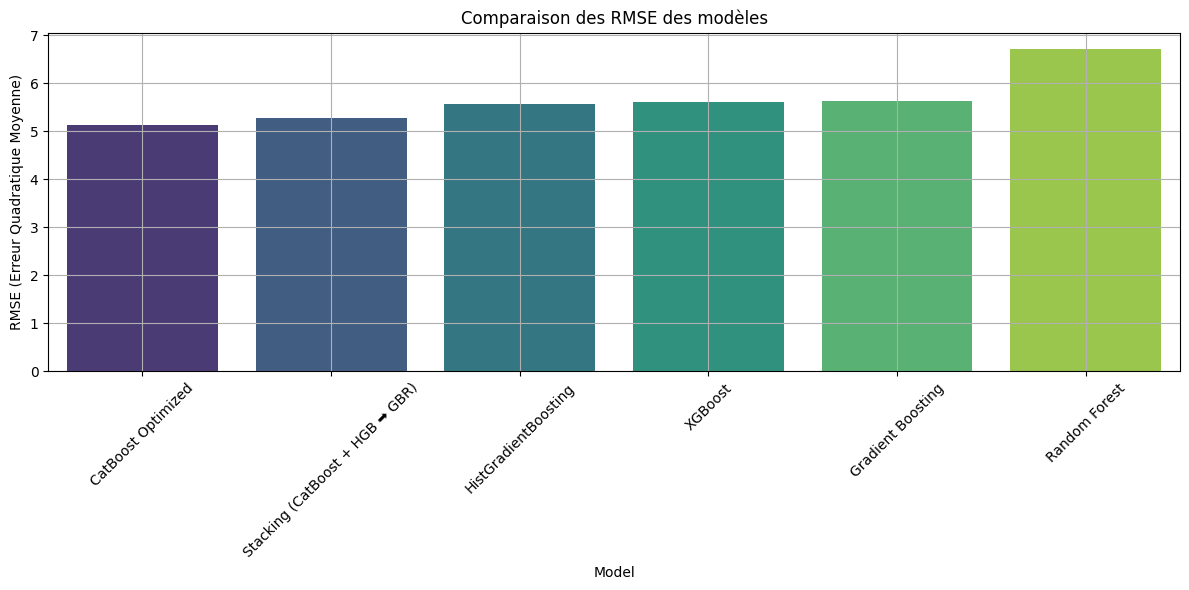

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='RMSE', data=results_df_sorted, palette='viridis')
plt.title('Comparaison des RMSE des modèles')
plt.xticks(rotation=45)
plt.ylabel("RMSE (Erreur Quadratique Moyenne)")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-58-9eb8ca401893>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=results_df_sorted, palette='viridis')


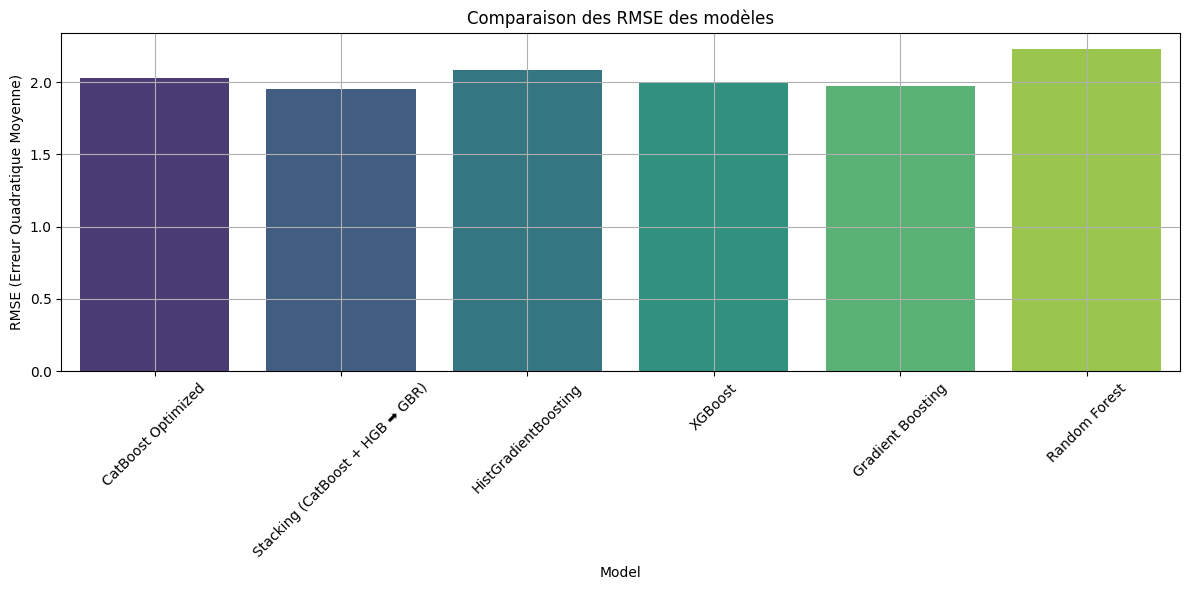

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='MAE', data=results_df_sorted, palette='viridis')
plt.title('Comparaison des RMSE des modèles')
plt.xticks(rotation=45)
plt.ylabel("RMSE (Erreur Quadratique Moyenne)")
plt.grid(True)
plt.tight_layout()
plt.show()


## **Scatter Plot: Actual vs Predicted**

In [59]:
model_preds = {
    'Random Forest': rf_preds,
    'XGBoost': xgb_preds,
    'Gradient Boosting': gb_preds,
    'HistGradientBoosting': hgb_preds,
    'CatBoost': cat_preds,
    'Stacking (Cat + HGB)': y_pred_stack
}


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


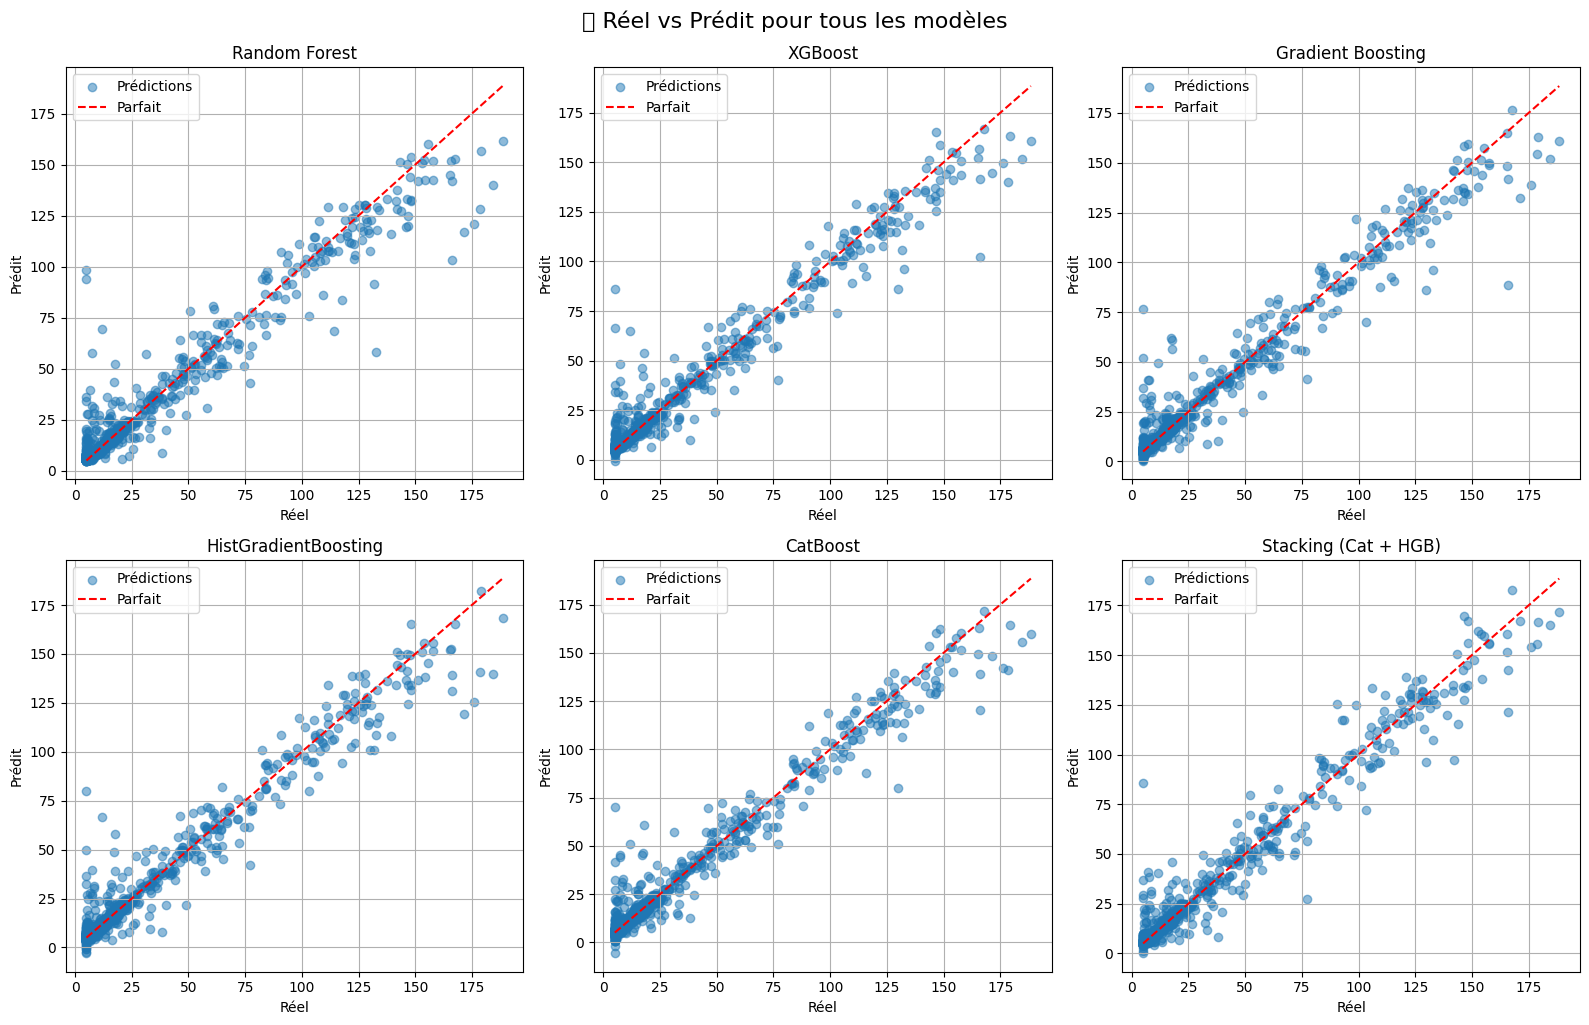

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

for i, (name, preds) in enumerate(model_preds.items(), 1):
    plt.subplot(2, 3, i)
    plt.scatter(y_test, preds, alpha=0.5, label='Prédictions')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Parfait')
    plt.title(f'{name}')
    plt.xlabel('Réel')
    plt.ylabel('Prédit')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle("📍 Réel vs Prédit pour tous les modèles", fontsize=16, y=1.02)
plt.show()


## **Résidus (Réel - Prédit) pour tous les modèles**

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


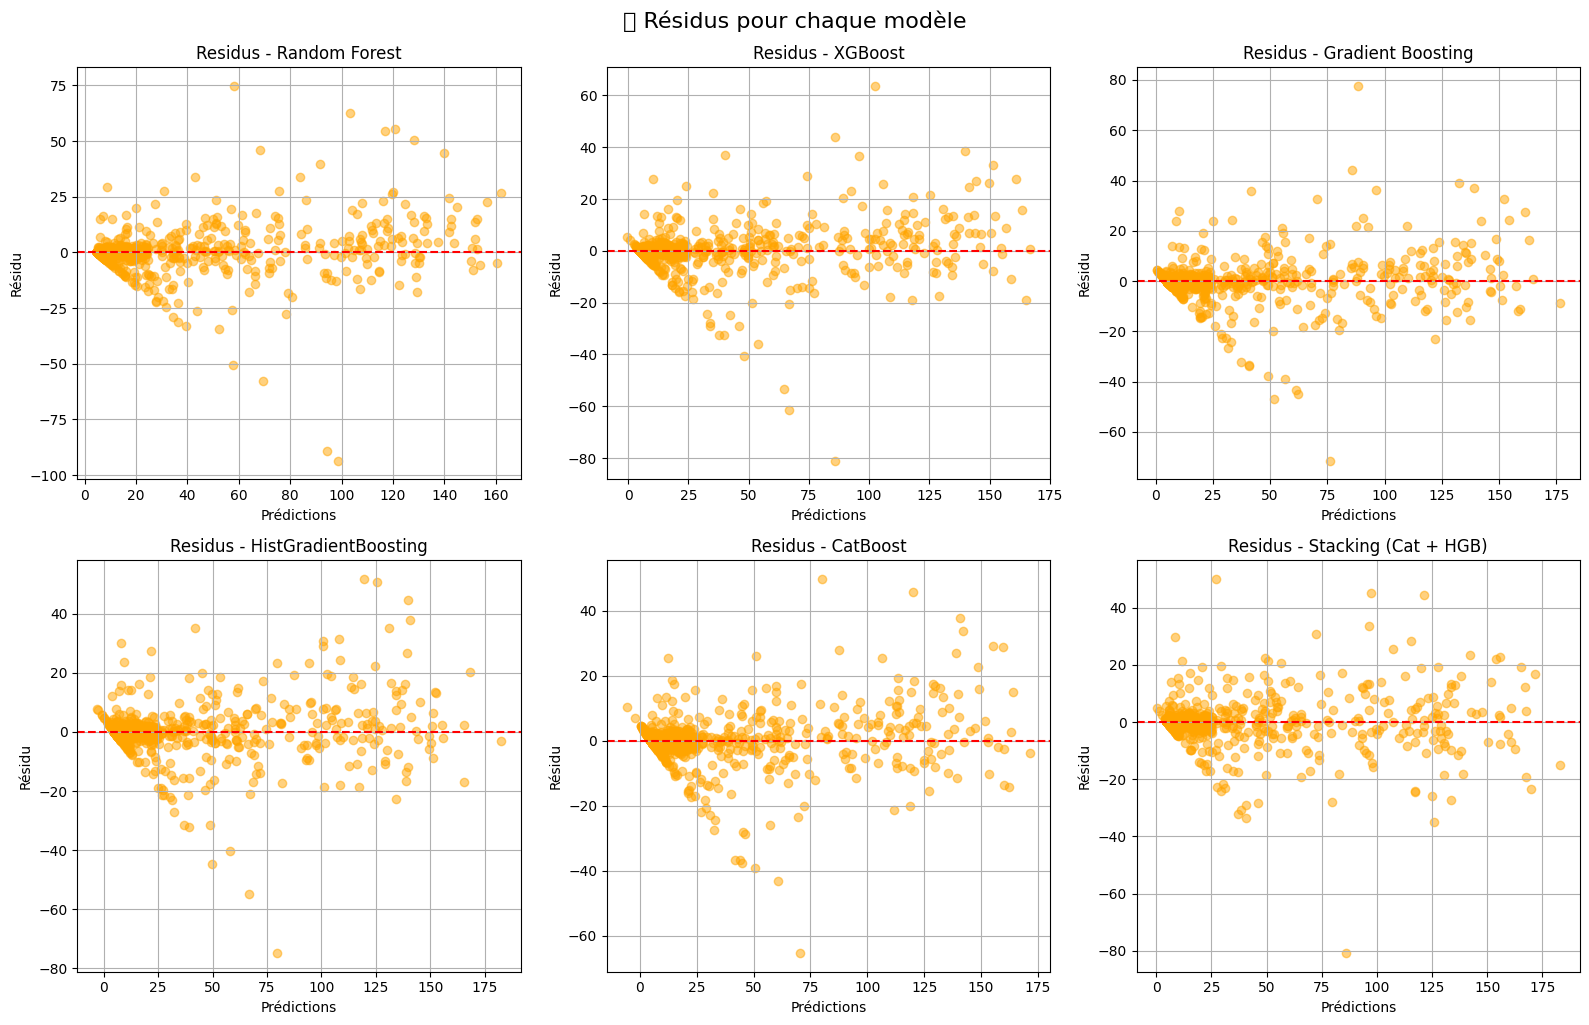

In [61]:
plt.figure(figsize=(16, 10))

for i, (name, preds) in enumerate(model_preds.items(), 1):
    residuals = y_test - preds
    plt.subplot(2, 3, i)
    plt.scatter(preds, residuals, alpha=0.5, color='orange')
    plt.axhline(0, linestyle='--', color='red')
    plt.title(f'Residus - {name}')
    plt.xlabel('Prédictions')
    plt.ylabel('Résidu')
    plt.grid(True)

plt.tight_layout()
plt.suptitle("📉 Résidus pour chaque modèle", fontsize=16, y=1.02)
plt.show()


## **Courbe de comparaison des prédictions (top 50)**

<ipython-input-62-68f712852680>:13: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


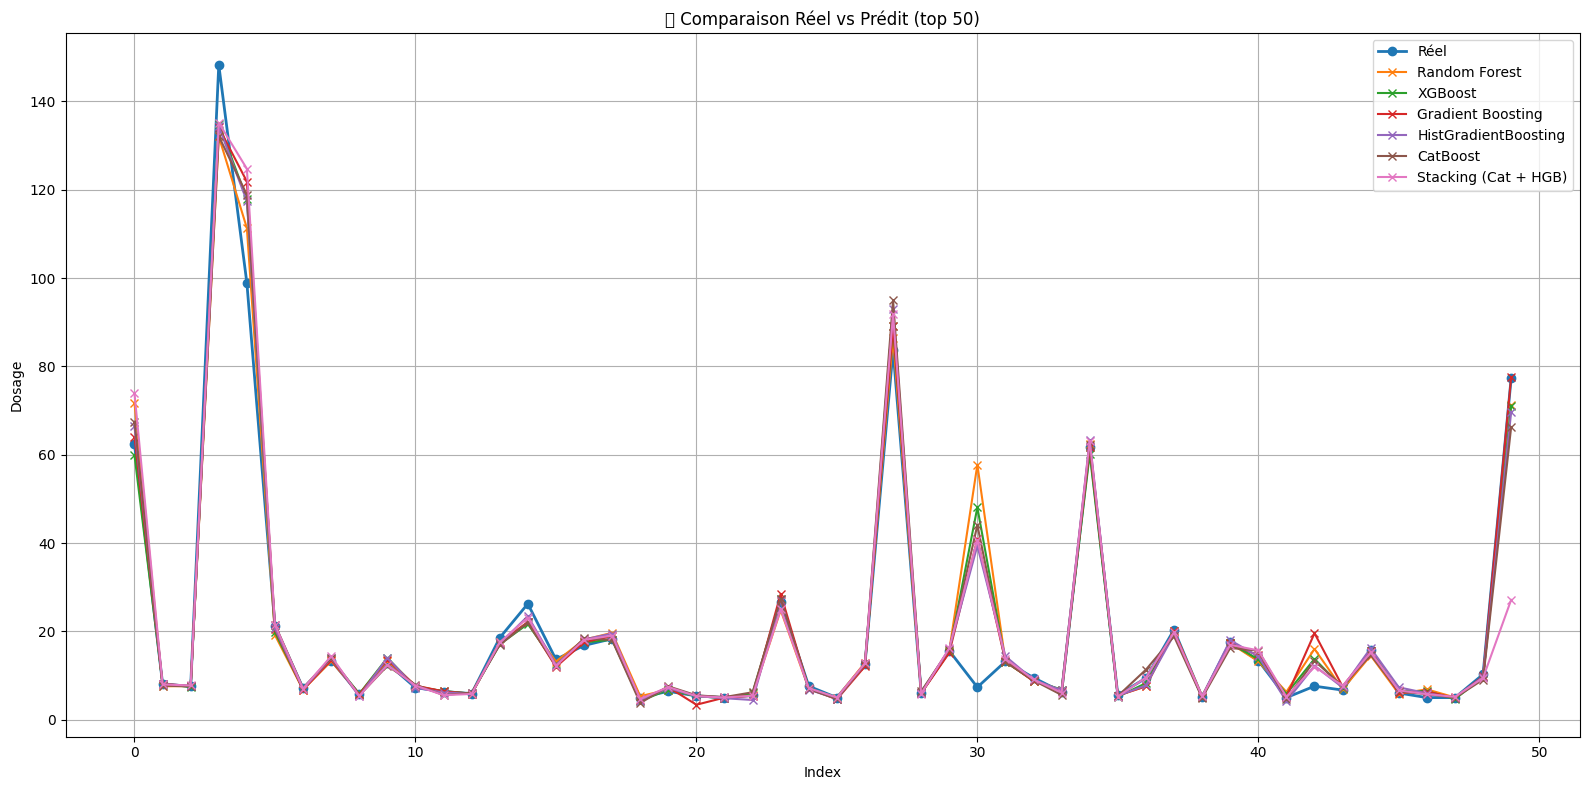

In [62]:
n = 50
plt.figure(figsize=(16, 8))
plt.plot(y_test[:n].values, label='Réel', marker='o', linewidth=2)

for name, preds in model_preds.items():
    plt.plot(preds[:n], label=name, marker='x')

plt.title(f"📈 Comparaison Réel vs Prédit (top {n})")
plt.xlabel('Index')
plt.ylabel('Dosage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **Testing**

In [63]:
import joblib
import pandas as pd

# ✅ Input Samples
input_samples = [
    {
        'Fertilizer Name': 33,
        'N (%)': 15, 'P (%)': 15, 'K (%)': 10, 'Fertilizer Type': 3,
        'Absorption Rate (%)': 75, 'Price per kg (TND)': 2.99,
        'State': 17, 'Region of Use in Tunisia': 0, 'Specific Crop': 1,
        'Crop N': 142, 'Crop P': 61, 'Crop K': 34,
        'Application Method': 0, 'Root Depth (cm)': 70,
        'Soil_P': 11.6, 'Soil_K': 77.3, 'Soil_N': 21.3, 'pH': 7.29,
        'Usage (Dosage)': 7.88
    },
    {
        'Fertilizer Name': 104,
        'N (%)': 12, 'P (%)': 0, 'K (%)': 0, 'Fertilizer Type': 0,
        'Absorption Rate (%)': 50, 'Price per kg (TND)': 1.79,
        'State': 0, 'Region of Use in Tunisia': 1, 'Specific Crop': 2,
        'Crop N': 146, 'Crop P': 70, 'Crop K': 40,
        'Application Method': 0, 'Root Depth (cm)': 80,
        'Soil_P': 19.562761919063, 'Soil_K': 93.0, 'Soil_N': 31.05890196823459, 'pH': 7.276328034179039,
        'Usage (Dosage)': 125.9
    },
    {
        'Fertilizer Name': 13,
        'N (%)': 5, 'P (%)': 10, 'K (%)': 15, 'Fertilizer Type': 2,
        'Absorption Rate (%)': 85, 'Price per kg (TND)': 2.13,
        'State': 21, 'Region of Use in Tunisia': 2, 'Specific Crop': 5,
        'Crop N': 41, 'Crop P': 73, 'Crop K': 79,
        'Application Method': 7, 'Root Depth (cm)': 60,
        'Soil_P': 24.41523178541777, 'Soil_K': 68.3, 'Soil_N': 19.89086676603514, 'pH': 8.156323256741699,
        'Usage (Dosage)': 46.25
    }
]

# 🔁 Feature Engineering
def preprocess_input(samples):
    df = pd.DataFrame(samples)
    df["NPK_ratio"] = df["N (%)"] / (df["P (%)"] + df["K (%)"] + 1e-3)
    df["N_gap"] = df["Crop N"] - df["N (%)"]
    df["P_gap"] = df["Crop P"] - df["P (%)"]
    df["K_gap"] = df["Crop K"] - df["K (%)"]
    df["Soil_P_suff"] = df["Soil_P"] / (df["Crop P"] + 1e-3)
    df["Soil_K_suff"] = df["Soil_K"] / (df["Crop K"] + 1e-3)
    df["Soil_N_suff"] = df["Soil_N"] / (df["Crop N"] + 1e-3)
    df["Effective_N"] = df["N (%)"] * df["Absorption Rate (%)"] / 100
    df["Effective_P"] = df["P (%)"] * df["Absorption Rate (%)"] / 100
    df["Effective_K"] = df["K (%)"] * df["Absorption Rate (%)"] / 100
    return df.drop(columns=["Fertilizer Name", "Usage (Dosage)"], errors="ignore")

# 🔢 Preprocessing
processed_input = preprocess_input(input_samples)
actual_dosages = [sample["Usage (Dosage)"] for sample in input_samples]

# 📦 Load Models
stacking_model = joblib.load("stacking_cat_hgb_gb_model.joblib")
hgb_model = joblib.load("hgb_best_model.joblib")
catboost_model = joblib.load("catboost_model.pkl")
xgboost_model = joblib.load("xgboost.pkl")
gradient_boosting_model = joblib.load("gradient_boosting_pipeline.pkl")
random_forest_model = joblib.load("randomForest.pkl")

# 🔮 Predictions
preds = {
    "Stacking": stacking_model.predict(processed_input),
    "HistGB": hgb_model.predict(processed_input),
    "CatBoost": catboost_model.predict(processed_input),
    "XGBoost": xgboost_model.predict(processed_input),
    "Gradient Boosting": gradient_boosting_model.predict(processed_input),
    "Random Forest": random_forest_model.predict(processed_input)
}

# 📊 Results
print("\n📌 Model Predictions (Dosage) and Errors:\n")
for i, sample in enumerate(input_samples):
    actual = actual_dosages[i]
    print(f"Sample {i+1} - Fertilizer ID: {sample['Fertilizer Name']} (Actual: {actual:.2f})")
    for model_name, predictions in preds.items():
        pred = predictions[i]
        diff = pred - actual
        print(f"   🔹 {model_name:20} → Predicted: {pred:.2f} | Diff: {diff:+.2f}")
    print()



📌 Model Predictions (Dosage) and Errors:

Sample 1 - Fertilizer ID: 33 (Actual: 7.88)
   🔹 Stacking             → Predicted: 7.91 | Diff: +0.03
   🔹 HistGB               → Predicted: 7.86 | Diff: -0.02
   🔹 CatBoost             → Predicted: 8.07 | Diff: +0.19
   🔹 XGBoost              → Predicted: 8.64 | Diff: +0.76
   🔹 Gradient Boosting    → Predicted: 8.10 | Diff: +0.22
   🔹 Random Forest        → Predicted: 7.67 | Diff: -0.21

Sample 2 - Fertilizer ID: 104 (Actual: 125.90)
   🔹 Stacking             → Predicted: 122.71 | Diff: -3.19
   🔹 HistGB               → Predicted: 122.33 | Diff: -3.57
   🔹 CatBoost             → Predicted: 122.19 | Diff: -3.71
   🔹 XGBoost              → Predicted: 124.26 | Diff: -1.64
   🔹 Gradient Boosting    → Predicted: 126.90 | Diff: +1.00
   🔹 Random Forest        → Predicted: 127.86 | Diff: +1.96

Sample 3 - Fertilizer ID: 13 (Actual: 46.25)
   🔹 Stacking             → Predicted: 48.66 | Diff: +2.41
   🔹 HistGB               → Predicted: 42.85 | Diff:

In [64]:
from google.colab import files

# 📦 Télécharger le fichier enregistré
files.download('stacking_cat_hgb_gb_model.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>